# Overview
**DayCent regional simulation results post-processing**

This Jupyter Notebook is designed to facilitate post-processing and analysis of sets of raw DayCent results from a regional scale simulation. For more information, contact author [John Field](https://johnlfield.weebly.com/) at <john.L.field@gmail.com>

## DayCent background

DayCent is a process-based model that simulates agro-ecosystem net primary production, soil organic matter dynamics, and nitrogen (N) cycling and trace gas emissions. DayCent is a daily-timestep version of the older CENTURY model. Both models were created and are currently maintained at the Colorado State University [Natural Resource Ecology Laboratory](https://www.nrel.colostate.edu/) (CSU-NREL), and source code is available upon request.  DayCent model homepage:  [https://www2.nrel.colostate.edu/projects/daycent/](https://www2.nrel.colostate.edu/projects/daycent/)

## Regional workflow

The primary spatial data inputs to DayCent are:
* soil texture as a function of depth
* historic daily weather (Tmin, Tmax, precip)

Our DayCent spatial modeling workflow is based on a national-scale GIS database of current land use ([NLCD](https://www.mrlc.gov/national-land-cover-database-nlcd-2016)), soil ([SSURGO](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_053627)), and weather ([NARR](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr)) data layers housed at CSU-NREL. The python-based workflow consists of a collection of scripts that perform the following:
1. Selection of area to be simulated, specified based on current land cover and/or land biophysical factors (i.e., soil texutre, slope, land capability class rating, etc.)
2. Determination of individual unique DayCent model runs (i.e., **"strata"**) necessary to cover the heterogenity of soils and climate across the simulation area
3. Parallel execution of simulations on the CSU-NREL computing cluster
4. Results analysis and mapping (this routine)

### TODO: add a section about these specific simulaions– the origin of the calibration, and the land use assumptions

## Simulating switchgrass on abandoned cropland

Simulating rainfed switchgrass, fertilized at 75 kg N ha-1 y-1, and replanted every 10 years. Amounts of abandoned cropland, and the date of peak cropland, for every county were taken from Zumkehr & Campbell 2013. Abandoned cropland randomly assigned (at 4km scale) to available X, Y & Z in each pixel as per the National Land Cover Database. Assumed unfertilized native grass during period of abandonment. 



>Zumkehr, A., & Campbell, J. E. (2013). Historical U.S. cropland areas and the potential for bioenergy production on abandoned croplands. Environmental Science & Technology, 47(8), 3840–3847. https://doi.org/10.1021/es3033132

Simuated yields of switchgrass and other energy crops can be compared against those from PRISM-EM, a hybrid modeling approach that combines PRISM climate data, biophysical limits to prodcutivity, and expert judgement. PRISM-EM energy grass results are described in:

>Lee, D. K., Aberle, E., Anderson, E. K., Anderson, W., Baldwin, B. S., Baltensperger, D., Barrett, M., Blumenthal, J., Bonos, S., Bouton, J., Bransby, D. I., Brummer, C., Burks, P. S., Chen, C., Daly, C., Egenolf, J., Farris, R. L., Fike, J. H., Gaussoin, R., … Owens, V. (2018). Biomass production of herbaceous energy crops in the United States: Field trial results and yield potential maps from the multiyear regional feedstock partnership. GCB Bioenergy, 10(10), 698–716. https://doi.org/10.1111/gcbb.12493

And PRISM-EM results for energy tree crops are described in:

>Volk, T. A., Berguson, B., Daly, C., Halbleib, M. D., Miller, R., Rials, T. G., Abrahamson, L. P., Buchman, D., Buford, M., Cunningham, M. W., Eisenbies, M., Fabio, E. S., Hallen, K., Heavey, J., Johnson, G. A., Kuzovkina, Y. A., Liu, B., Mcmahon, B., Rousseau, R., … Wright, J. (2018). Poplar and shrub willow energy crops in the United States: Field trial results from the multiyear regional feedstock partnership and yield potential maps based on the PRISM‐ELM model. GCB Bioenergy, 10(10), 735–751. https://doi.org/10.1111/gcbb.12498

# Data structures & flow

Listen in the order in which they are introduced. 

- run_df = DayCent simulation runtable
- lis_df = all concatenated DayCent .lis simulation timeseries
- ys_df = all concatenated DayCent year_summary.out simulation timeseries
- df = merged lis_df & ys_df simulation timeseries (filtering & unit conversion applied to this dataframe)
- area_df = strata areas (from run_df) merged to simulation timeseries (df)
- area_tot_df = intermediate dataframe for timeseries production & flux totals across strata area (intermediate step in area-weighting)
- annual_df (saved output) = county-level (area-weighted) timeseries production & fluxes
- county_df (saved output) = county-level mean, STD & COV production & fluxes
- norm_df (saved output) = normalized county-level yield time-series (for exploring regional precip sensitivity)
- reg_df (saved output) = r2 values capturing strength of yield–precip relationship in each county
- frr_df = mapping Farm Resource Regions by county
- cabbi_df = county-average Miscanthus yield data from Jeff Kent circa Nov 2021
- coa_df = USDA Census of Agriculture cropland area data

In [1]:
# start a timer to track total notebook execution time

from datetime import datetime
start_time = datetime.now()

# Code & data imports

## Load python modules

In [2]:
import constants as con
from IPython.display import Image, display
import json
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

## Load runtable

Individual DayCent strata are specified via a .csv format "runtable" file, which contains the following information:
* unique identifier (strata_no)
* ID for DayCent spin-up archive (runno)
* SSURGO soil map unit ID (mukey_int)
* NARR climate grid ID (gridx & gridy)
* county FIPS code (fips)
* DayCent-format schedule file to simulate (sch_file)
* latitude of the county centroid, used to set perennial grass phenology (latitude)
* for simulations on abandoned agricultural land, year of peak ag land extent (peak_year)
* land area represented by that strata (tot_ha)
The code below loads the relevant runtable to a Pandas dataframe.

In [3]:
runtable = "01_raw_inputs/ContUS_runtable_incl81.csv"
run_df = pd.read_csv(runtable, skiprows=[1])   # skip SQL datatype row
run_df

,strata_no,runno,mukey_int,gridx,gridy,fips,sch_file,latitude,peak_year,tot_ha
0,1,8942,328058,89,234,1001,idle_switchgrass75.sch,32.534931,1950,165.751842
1,2,17925,328059,89,234,1001,idle_switchgrass75.sch,32.534931,1950,17.960497
2,3,27012,328060,89,234,1001,idle_switchgrass75.sch,32.534931,1950,235.329205
3,4,36132,328061,89,234,1001,idle_switchgrass75.sch,32.534931,1950,2.221341
4,5,45302,328062,89,234,1001,idle_switchgrass75.sch,32.534931,1950,63.330603
...,...,...,...,...,...,...,...,...,...,...
511039,568862,4490928,2516980,122,181,56045,idle_switchgrass75.sch,43.840485,2000,1.026365
511040,568863,4490985,2516988,122,181,56045,idle_switchgrass75.sch,43.840485,2000,5.069576
511041,568864,4490997,2516989,122,181,56045,idle_switchgrass75.sch,43.840485,2000,57.401776
511042,568865,4491000,2516990,122,181,56045,idle_switchgrass75.sch,43.840485,2000,25.088445


In [4]:
# extract the total count of strata & counties simulated

run_strata = len(run_df.strata_no.unique())
print('Target strata:', run_strata)

run_counties = len(run_df.fips.unique())
print('Target counties:', run_counties)

Target strata: 511044
Target counties: 2887


## Load DayCent results

Raw DayCent model output is spread across two files:
* .lis files contain information related to per-area biomass harvest and soil carbon
* year_summary.out contains per-area trace gas emissions

First, we load and concatenate the .lis output for the relevant switchgrass variety scenarios. 

In [5]:
# specify & explore .lis output

results_path = '/Users/53f/Desktop/daycent_data/'

# specify the "base" simulation results which will be analyzed
# (earlier versions of this code also considered an alterative set of "treatment" results)
base_sims = '2019-09-16,13.26__eastern_US_runtable_incl81__79__CBI_baseline'
base_lis_fpath = os.path.join(results_path, base_sims+'/X.lis')

# read the first few rows
with open(base_lis_fpath) as myfile:
    head = [next(myfile) for x in range(5)]
head

['strata_no,crop,land_type,time,cgrain,crmvst,shrema,somsc,strmac(2),volpac,bglivcj,bglivcm,prcann,irrtot,d_somsc\n',
 'INT,TEXT,TEXT,INT,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL\n',
 '1,idle,switchgrass75,1975,0.0,0.0,0.0,2045.027,0.0,0.0,0.0,0.0,0.0,0.0,0.0\n',
 '1,idle,switchgrass75,1976,0.0,0.0,165.812,2069.303,1.791,1.053,70.092,63.722,155.117,0.0,24.276\n',
 '1,idle,switchgrass75,1977,0.0,0.0,81.098,2108.282,0.395,0.587,39.844,57.04,127.419,0.0,38.979\n']

In [6]:
# to save time & memory, only upload the specific data columns that will be used in subsequent analysis
lis_cols = ['strata_no', 'time', 'crmvst', 'somsc', 'strmac(2)', 'volpac', 'd_somsc']

# .lis data import, skipping SQL datatype rows
base_lis_df = pd.read_csv(base_lis_fpath, skiprows=[1], usecols=lis_cols)
base_lis_df['variety'] = 'base'

lis_df = base_lis_df

Note that my DayCent workflow has an indexing issue with the .lis output. In this output, year 2022 is a dummy row, and the real 2022 results show up in the 2023 row, with all subsequent results frame-shifted accordingly. Thus, we have to drop the 2022 row, and shift the time index in all subsequent rows:

In [7]:
lis_df = lis_df[lis_df.time != 2021].copy()
lis_df['time'] = np.where(lis_df['time'] > 2021, lis_df['time'] - 1, lis_df['time'])
lis_df

,strata_no,time,crmvst,somsc,strmac(2),volpac,d_somsc,variety
0,1,1975,0.000,2045.027,0.000,0.000,0.000,base
1,1,1976,0.000,2069.303,1.791,1.053,24.276,base
2,1,1977,0.000,2108.282,0.395,0.587,38.979,base
3,1,1978,0.000,2154.458,0.201,0.627,46.176,base
4,1,1979,0.000,2225.041,0.374,0.693,70.583,base
...,...,...,...,...,...,...,...,...
39293624,493334,2064,787.069,6037.354,4.942,0.939,-14.970,base
39293625,493334,2065,754.694,6022.022,7.293,0.901,-15.332,base
39293626,493334,2066,776.439,6038.615,2.396,0.932,16.593,base
39293627,493334,2067,727.310,6042.271,1.983,0.875,3.656,base


Then, we do the same for the year_summary.out results.

In [8]:
ys_cols = ['strata_no', 'time', 'N2Oflux', 'NOflux', 'CH4', 'ANNPPT']

# year_summary.out data import, skipping SQL datatype rows
base_ys_fpath = os.path.join(results_path, base_sims+'/year_summary.out')
base_ys_df = pd.read_csv(base_ys_fpath, skiprows=[1], usecols=ys_cols)
base_ys_df['variety'] = 'base'

ys_df = base_ys_df
ys_df

,strata_no,time,N2Oflux,NOflux,CH4,ANNPPT,variety
0,1,1975,0.071433,0.054203,0.221034,155.116974,base
1,1,1976,0.013492,0.030303,0.247949,127.419052,base
2,1,1977,0.020945,0.032218,0.246919,118.088028,base
3,1,1978,0.022181,0.041216,0.216468,144.686295,base
4,1,1979,0.020329,0.039546,0.214066,173.853271,base
...,...,...,...,...,...,...,...
38846991,493334,2064,0.173611,0.193514,0.158910,82.707146,base
38846992,493334,2065,0.187314,0.174329,0.139219,100.763603,base
38846993,493334,2066,0.096663,0.139531,0.207670,63.053139,base
38846994,493334,2067,0.210782,0.183350,0.173178,83.564400,base


# DayCent results analysis

## Merge .lis & .out data

In [9]:
# merge .lis & year_summary.out DataFrames
df = pd.merge(lis_df, ys_df, on=['strata_no', 'variety', 'time'], validate='1:1')
df

,strata_no,time,crmvst,somsc,strmac(2),volpac,d_somsc,variety,N2Oflux,NOflux,CH4,ANNPPT
0,1,1975,0.000,2045.027,0.000,0.000,0.000,base,0.071433,0.054203,0.221034,155.116974
1,1,1976,0.000,2069.303,1.791,1.053,24.276,base,0.013492,0.030303,0.247949,127.419052
2,1,1977,0.000,2108.282,0.395,0.587,38.979,base,0.020945,0.032218,0.246919,118.088028
3,1,1978,0.000,2154.458,0.201,0.627,46.176,base,0.022181,0.041216,0.216468,144.686295
4,1,1979,0.000,2225.041,0.374,0.693,70.583,base,0.020329,0.039546,0.214066,173.853271
...,...,...,...,...,...,...,...,...,...,...,...,...
38846991,493334,2064,787.069,6037.354,4.942,0.939,-14.970,base,0.173611,0.193514,0.158910,82.707146
38846992,493334,2065,754.694,6022.022,7.293,0.901,-15.332,base,0.187314,0.174329,0.139219,100.763603
38846993,493334,2066,776.439,6038.615,2.396,0.932,16.593,base,0.096663,0.139531,0.207670,63.053139
38846994,493334,2067,727.310,6042.271,1.983,0.875,3.656,base,0.210782,0.183350,0.173178,83.564400


In [10]:
# check no. of strata in merged results for consistency w/ runtable

print("Unique runtable strata count:", run_df.strata_no.nunique())
print("Unique DayCent output strata count:", df.strata_no.nunique())

Unique runtable strata count: 511044
Unique DayCent output strata count: 446633


## Unit conversions

Most DayCent outputs are in units of grams of carbon per meter squared (g C m-2), though some of the nitrogen flux results are reported on a per-hectare basis instead. The code below performs basic unit converions to express the results in more familiar units of kg or Mg per hectare. 

In [11]:
# unit conversions
df['yield_Mg_per_ha'] = ((df['crmvst'] * con.g_m2_to_Mg_ha) / con.c_concentration)
df['SOC_MgC_per_ha'] = (df['somsc'] * con.g_m2_to_Mg_ha)
df['dSOC_MgC_per_ha'] = (df['d_somsc'] * con.g_m2_to_Mg_ha)
df['dN2ON_kgN_per_ha'] = (df['N2Oflux'] * con.g_m2_to_kg_ha)
df['iN2ON_kgN_per_ha'] = ((0.0075 * df['strmac(2)'] + 0.01 * df['volpac'] +
                           0.01 * df['NOflux']) * con.g_m2_to_kg_ha)
df['kgCH4_ox_per_ha'] = (df['CH4'] * con.g_m2_to_kg_ha)
df['ghg_MgCO2e_per_ha'] = (df['dSOC_MgC_per_ha'] * con.c_to_co2 * -1.0) + \
                           ((df['dN2ON_kgN_per_ha'] + df['iN2ON_kgN_per_ha']) *
                            con.kg_ha_to_Mg_ha * con.n_to_n2o * con.n2o_gwp100_ar5) + \
                    (df['kgCH4_ox_per_ha'] * con.kg_ha_to_Mg_ha * con.ch4_gwp100_ar5 * -1.0)
df['volit_kgN_per_ha'] = df['volpac'] * con.g_m2_to_kg_ha
df['leached_kgN_per_ha'] = df['strmac(2)'] * con.g_m2_to_kg_ha

# rename annual precipitation data column
df.rename(columns={'ANNPPT': 'annual_precip_cm'}, inplace=True)

# drop the original columns with non-standard unit data
df.drop(columns=['crmvst', 'somsc', 'd_somsc', 'N2Oflux',
                 'strmac(2)', 'volpac', 'NOflux', 'CH4'], inplace=True)

## Extract initial SOC values

In [12]:
# select the row with the lowest 'time' value in each strata_no group, and propagate the associated SOC values

init_SOC_df = df[['strata_no', 'time', 'SOC_MgC_per_ha']].loc[df.groupby('strata_no').time.idxmin()]
init_SOC_df.rename(columns={'SOC_MgC_per_ha': 'initSOC_MgC_per_ha'}, inplace=True)
init_SOC_df

,strata_no,time,initSOC_MgC_per_ha
0,1,1975,20.45027
3531851,2,1975,20.47634
7062390,3,1975,13.78600
10594734,4,1975,16.73005
14125755,5,1975,13.23958
...,...,...,...
24720748,493330,1978,49.19578
28251761,493331,1980,49.19578
31784117,493332,1978,31.98083
35314403,493333,1978,57.94762


In [13]:
# reassociate these strata-level initial SOC results with the main dataframe

df = df.merge(init_SOC_df[['strata_no', 'initSOC_MgC_per_ha']], on='strata_no') 

Plotting strata 1
   strata_no  time  initSOC_MgC_per_ha
0          1  1975            20.45027

Plotting strata 56079
          strata_no  time  initSOC_MgC_per_ha
18070913      56079  1975            29.10586

Plotting strata 109204
          strata_no  time  initSOC_MgC_per_ha
36093627     109204  1990            41.71864

Plotting strata 162531
          strata_no  time  initSOC_MgC_per_ha
15284952     162531  1975            24.08543

Plotting strata 221928
          strata_no  time  initSOC_MgC_per_ha
33345516     221928  1975             23.6238

Plotting strata 277167
          strata_no  time  initSOC_MgC_per_ha
12557202     277167  1975            49.23046

Plotting strata 331816
          strata_no  time  initSOC_MgC_per_ha
30609301     331816  1975            33.32388

Plotting strata 386619
         strata_no  time  initSOC_MgC_per_ha
9829477     386619  1975            19.60987

Plotting strata 439730
          strata_no  time  initSOC_MgC_per_ha
27878378     439730  1993

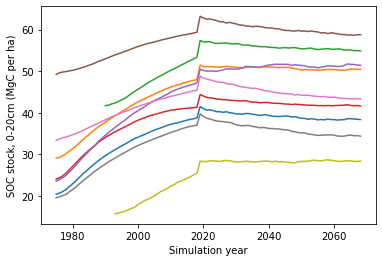

In [14]:
# iterate through the list of distinct strata

all_strata = df.strata_no.unique()
all_strata.sort()

for i, strata in enumerate(all_strata):

    # plot only one result for every X rows of strata results
    divisor = 50000
    if i % divisor == 0:

        print('Plotting strata', strata)
        print(init_SOC_df[init_SOC_df.strata_no == strata])
        strata_df = df[df.strata_no == strata]
        plt.plot(strata_df['time'], strata_df['SOC_MgC_per_ha'], label=str(strata))
        print()

# plt.legend(title='Strata')
plt.xlabel('Simulation year')
plt.ylabel('SOC stock, 0-20cm (MgC per ha)')
plt.savefig('03_figure_outputs/Representative_SOC_traces.png')
plt.show()

In [15]:
# drop all results prior to the start of switchgrass harvest, and stop after a single loop through the 35-year NARR record
start_y = 2022
end_y = 2056
df = df[df['time'].between(start_y, end_y)].copy()

print('Target nubmber of rows:', ((end_y - start_y) + 1) * run_strata)
df

Target nubmber of rows: 17886540


,strata_no,time,variety,annual_precip_cm,yield_Mg_per_ha,SOC_MgC_per_ha,dSOC_MgC_per_ha,dN2ON_kgN_per_ha,iN2ON_kgN_per_ha,kgCH4_ox_per_ha,ghg_MgCO2e_per_ha,volit_kgN_per_ha,leached_kgN_per_ha,initSOC_MgC_per_ha
47,1,2022,base,137.576752,21.391156,40.72446,0.08657,1.12298,0.490433,2.37433,0.288055,11.68,48.32,20.45027
48,1,2023,base,138.745132,23.656467,40.52146,-0.20300,1.36280,0.363247,2.03076,1.405571,12.66,29.63,20.45027
49,1,2024,base,146.166794,23.951467,40.27125,-0.25021,1.38067,0.551492,2.00467,1.665096,12.81,54.49,20.45027
50,1,2025,base,111.499336,22.336978,40.27625,0.00500,1.19326,0.233781,2.51507,0.505397,12.20,13.22,20.45027
51,1,2026,base,133.419678,25.769089,40.10837,-0.16788,1.52986,0.433505,2.19189,1.371183,13.74,37.75,20.45027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38846979,493334,2052,base,57.769497,17.229333,62.05742,0.11422,1.53233,0.236046,1.92373,0.263879,9.35,17.21,51.82037
38846980,493334,2053,base,84.475510,16.436422,61.89009,-0.16733,2.01088,0.359963,1.80432,1.549671,8.89,33.48,51.82037
38846981,493334,2054,base,85.811035,17.345111,61.69205,-0.19804,2.54505,0.186757,1.66824,1.816289,9.32,9.81,51.82037
38846982,493334,2055,base,82.782486,15.130156,61.64329,-0.04876,2.18355,0.526795,1.36491,1.268876,8.24,56.91,51.82037


In [16]:
# re-associate FIPS codes and land areas with strata results

area_df = pd.merge(run_df[['strata_no', 'fips', 'tot_ha']], df, on='strata_no', validate='1:m')
area_df

,strata_no,fips,tot_ha,time,variety,annual_precip_cm,yield_Mg_per_ha,SOC_MgC_per_ha,dSOC_MgC_per_ha,dN2ON_kgN_per_ha,iN2ON_kgN_per_ha,kgCH4_ox_per_ha,ghg_MgCO2e_per_ha,volit_kgN_per_ha,leached_kgN_per_ha,initSOC_MgC_per_ha
0,1,1001,165.751842,2022,base,137.576752,21.391156,40.72446,0.08657,1.12298,0.490433,2.37433,0.288055,11.68,48.32,20.45027
1,1,1001,165.751842,2023,base,138.745132,23.656467,40.52146,-0.20300,1.36280,0.363247,2.03076,1.405571,12.66,29.63,20.45027
2,1,1001,165.751842,2024,base,146.166794,23.951467,40.27125,-0.25021,1.38067,0.551492,2.00467,1.665096,12.81,54.49,20.45027
3,1,1001,165.751842,2025,base,111.499336,22.336978,40.27625,0.00500,1.19326,0.233781,2.51507,0.505397,12.20,13.22,20.45027
4,1,1001,165.751842,2026,base,133.419678,25.769089,40.10837,-0.16788,1.52986,0.433505,2.19189,1.371183,13.74,37.75,20.45027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14119835,493334,48207,8.799755,2052,base,57.769497,17.229333,62.05742,0.11422,1.53233,0.236046,1.92373,0.263879,9.35,17.21,51.82037
14119836,493334,48207,8.799755,2053,base,84.475510,16.436422,61.89009,-0.16733,2.01088,0.359963,1.80432,1.549671,8.89,33.48,51.82037
14119837,493334,48207,8.799755,2054,base,85.811035,17.345111,61.69205,-0.19804,2.54505,0.186757,1.66824,1.816289,9.32,9.81,51.82037
14119838,493334,48207,8.799755,2055,base,82.782486,15.130156,61.64329,-0.04876,2.18355,0.526795,1.36491,1.268876,8.24,56.91,51.82037


First, we combine the total production and impacts associated with each strata in each year by multiplying the per-ha results with the area represented by each strata:

In [17]:
# calculate strata totals & drop obsolete data
area_tot_df = area_df.copy(deep=False)

weight_cols = ['yield_Mg', 'initSOC_MgC', 'SOC_MgC', 'dSOC_MgC', 'dN2ON_kgN', 'iN2ON_kgN',
               'kgCH4_ox', 'ghg_MgCO2e', 'volit_kgN', 'leached_kgN']

for col in weight_cols:
    area_tot_df[col] = area_tot_df[col+'_per_ha'] * area_tot_df['tot_ha']
    area_tot_df.drop(columns=[col+'_per_ha'], inplace=True)

area_tot_df['annual_precip_cm_ha'] = area_tot_df['annual_precip_cm'] * area_tot_df['tot_ha']
area_tot_df.drop(columns=['annual_precip_cm'], inplace=True)

area_tot_df

,strata_no,fips,tot_ha,time,variety,yield_Mg,initSOC_MgC,SOC_MgC,dSOC_MgC,dN2ON_kgN,iN2ON_kgN,kgCH4_ox,ghg_MgCO2e,volit_kgN,leached_kgN,annual_precip_cm_ha
0,1,1001,165.751842,2022,base,3545.623436,3389.669922,6750.154259,14.349137,186.136004,81.290157,393.549571,47.745669,1935.981515,8009.129005,22803.600060
1,1,1001,165.751842,2023,base,3921.102925,3389.669922,6716.506636,-33.647624,225.886610,60.208926,336.602211,232.975980,2098.418320,4911.227078,22997.261198
2,1,1001,165.751842,2024,base,3969.999719,3389.669922,6675.033867,-41.472768,228.848596,91.410749,332.277745,275.992725,2123.281096,9031.817871,24227.415345
3,1,1001,165.751842,2025,base,3702.395211,3389.669922,6675.862626,0.828759,197.785043,38.749582,416.877485,83.770447,2022.172472,2191.239351,18481.220324
4,1,1001,165.751842,2026,base,4271.273950,3389.669922,6648.036207,-27.826419,253.577113,71.854319,363.309805,227.276178,2277.430309,6257.132035,22114.557388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14119835,493334,48207,8.799755,2052,base,151.613912,456.006560,546.090092,1.005108,13.484129,2.077145,16.928353,2.322066,82.277709,151.443784,508.357420
14119836,493334,48207,8.799755,2053,base,144.636489,456.006560,544.617629,-1.472463,17.695251,3.167586,15.877574,13.636723,78.229822,294.615797,743.363792
14119837,493334,48207,8.799755,2054,base,152.632728,456.006560,542.874925,-1.742703,22.395816,1.643419,14.680103,15.982902,82.013717,86.325597,755.116084
14119838,493334,48207,8.799755,2055,base,133.141662,456.006560,542.445849,-0.429076,19.214705,4.635664,12.010874,11.165800,72.509981,500.794057,728.465595


Then, we aggregate these results to the county scale, and divide by the total area simulated for each county to calculate area-weighted results:

In [18]:
# aggregate strata results to county scale
annual_df = area_tot_df.groupby(['fips', 'variety', 'time'], as_index=False).sum()
annual_df.drop(columns=['strata_no'], inplace=True)

print('Target nubmber of rows:', ((end_y - start_y) + 1) * run_counties)
annual_df

Target nubmber of rows: 101045


,fips,variety,time,tot_ha,yield_Mg,initSOC_MgC,SOC_MgC,dSOC_MgC,dN2ON_kgN,iN2ON_kgN,kgCH4_ox,ghg_MgCO2e,volit_kgN,leached_kgN,annual_precip_cm_ha
0,1001,base,2022,31214.547584,579359.913472,495119.582059,1.080294e+06,-138.582363,31967.398085,14955.407440,61802.132673,18313.316145,322619.245049,1.509958e+06,4.162874e+06
1,1001,base,2023,31214.547584,691132.360283,495119.582059,1.070494e+06,-9800.185753,41154.001480,13759.528289,50423.040514,57359.490990,374272.750382,1.261694e+06,4.241599e+06
2,1001,base,2024,31214.547584,748897.543258,495119.582059,1.060812e+06,-9682.259161,41159.170444,14918.022091,48750.247525,57458.722680,402147.091427,1.380530e+06,4.555630e+06
3,1001,base,2025,31214.547584,713269.996245,495119.582059,1.058687e+06,-2124.666695,35427.783299,7546.234805,62756.988442,23919.656544,390486.493195,4.239652e+05,3.634079e+06
4,1001,base,2026,31214.547584,771124.852151,495119.582059,1.053787e+06,-4900.631314,38732.796158,14035.670593,57333.876503,38320.653298,413742.146986,1.260225e+06,4.118852e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86095,48207,base,2052,12213.624489,198022.088348,546931.804987,6.433064e+05,-1167.414674,25229.645416,3379.381710,18089.519503,15682.149107,107206.739647,2.786102e+05,9.382590e+05
86096,48207,base,2053,12213.624489,178562.915983,546931.804987,6.422457e+05,-1060.669631,23561.947507,6185.795650,16230.408379,15817.181139,97595.447831,6.651255e+05,1.015257e+06
86097,48207,base,2054,12213.624489,190487.059361,546931.804987,6.402004e+05,-2045.299474,24518.037021,6310.466890,14149.688495,19933.149739,102865.753031,6.781502e+05,1.083561e+06
86098,48207,base,2055,12213.624489,185725.363121,546931.804987,6.384792e+05,-1721.193804,24055.051584,4266.262496,15321.162669,17668.954479,100768.292148,4.045969e+05,9.221258e+05


In [19]:
# calculate total county production in mega-tonne (Mt) units
annual_df['prod_Mt'] = annual_df['yield_Mg'] * 1.0e-6

In [20]:
# divide county by area to get back to weighted average per-area numbers & drop obsolete data
for col in weight_cols:
    annual_df[col+'_per_ha'] = annual_df[col] / annual_df['tot_ha']
    annual_df.drop(columns=[col], inplace=True)

annual_df['annual_precip_cm'] = annual_df['annual_precip_cm_ha'] / annual_df['tot_ha']
annual_df.drop(columns=['annual_precip_cm_ha'], inplace=True)

# calculate fraction of annual N application lost via leaching + volatilization
annual_df['leach_volit_frac'] = (annual_df['volit_kgN_per_ha'] + 
                                          annual_df['leached_kgN_per_ha']) / 75.0
    
annual_df

,fips,variety,time,tot_ha,prod_Mt,yield_Mg_per_ha,initSOC_MgC_per_ha,SOC_MgC_per_ha,dSOC_MgC_per_ha,dN2ON_kgN_per_ha,iN2ON_kgN_per_ha,kgCH4_ox_per_ha,ghg_MgCO2e_per_ha,volit_kgN_per_ha,leached_kgN_per_ha,annual_precip_cm,leach_volit_frac
0,1001,base,2022,31214.547584,0.579360,18.560574,15.861822,34.608681,-0.004440,1.024119,0.479117,1.979914,0.586692,10.335541,48.373541,133.363254,0.782788
1,1001,base,2023,31214.547584,0.691132,22.141354,15.861822,34.294719,-0.313962,1.318424,0.440805,1.615370,1.837588,11.990331,40.420055,135.885338,0.698805
2,1001,base,2024,31214.547584,0.748898,23.991940,15.861822,33.984535,-0.310184,1.318589,0.477919,1.561780,1.840767,12.883323,44.227134,145.945734,0.761473
3,1001,base,2025,31214.547584,0.713270,22.850563,15.861822,33.916468,-0.068067,1.134977,0.241754,2.010505,0.766298,12.509760,13.582295,116.422594,0.347894
4,1001,base,2026,31214.547584,0.771125,24.704021,15.861822,33.759470,-0.156998,1.240857,0.449652,1.836768,1.227654,13.254786,40.373014,131.952975,0.715037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86095,48207,base,2052,12213.624489,0.198022,16.213212,44.780467,52.671209,-0.095583,2.065697,0.276690,1.481093,1.283988,8.777635,22.811430,76.820681,0.421188
86096,48207,base,2053,12213.624489,0.178563,14.619978,44.780467,52.584365,-0.086843,1.929153,0.506467,1.328877,1.295044,7.990703,54.457671,83.124937,0.832645
86097,48207,base,2054,12213.624489,0.190487,15.596276,44.780467,52.416905,-0.167460,2.007433,0.516674,1.158517,1.632042,8.422213,55.524078,88.717400,0.852617
86098,48207,base,2055,12213.624489,0.185725,15.206408,44.780467,52.275981,-0.140924,1.969526,0.349304,1.254432,1.446659,8.250482,33.126684,75.499763,0.551696


## Time-averaging

Finally, we aggregate over simulation years to get time-averaged county-scale results:

In [21]:
# do mean aggregation to county scale, and drop superfluous columns
county_df = annual_df.groupby(['fips', 'variety'], as_index=False).mean()
county_df.drop(columns=['time'], inplace=True)

# perform the yield standard deviation aggregation separately (could have been done in the same step as means, but would have required writing
# out all columns, and would result in a hierarchical column name structure)
sd_df = annual_df[['fips', 'variety', 'yield_Mg_per_ha']].groupby(['fips', 'variety'], as_index=False).std()
sd_df.rename(columns={'yield_Mg_per_ha': 'yield_Mg_per_ha_std'}, inplace=True)
sd_df

# Re-associate std dataframe with mean data, and calculate yield COV
county_df = pd.merge(county_df, sd_df, on=['fips', 'variety'])
county_df['yield_Mg_per_ha_cov'] = county_df.yield_Mg_per_ha_std / county_df.yield_Mg_per_ha

print('Target nubmber of rows:', run_counties)
county_df

Target nubmber of rows: 2887


,fips,variety,tot_ha,prod_Mt,yield_Mg_per_ha,initSOC_MgC_per_ha,SOC_MgC_per_ha,dSOC_MgC_per_ha,dN2ON_kgN_per_ha,iN2ON_kgN_per_ha,kgCH4_ox_per_ha,ghg_MgCO2e_per_ha,volit_kgN_per_ha,leached_kgN_per_ha,annual_precip_cm,leach_volit_frac,yield_Mg_per_ha_std,yield_Mg_per_ha_cov
0,1001,base,31214.547584,0.677966,21.719545,15.861822,32.230748,-0.116743,1.272302,0.445954,1.791451,1.092976,11.806342,41.762400,130.097838,0.714250,2.663856,0.122648
1,1003,base,19794.098716,0.426953,21.569711,14.308916,28.110492,-0.123493,1.161068,0.502928,1.580146,1.101037,11.681393,49.533610,147.287666,0.816200,1.675040,0.077657
2,1005,base,34348.741190,0.773867,22.529695,15.007400,31.356354,-0.124292,1.214121,0.432390,1.873734,1.088464,12.272412,39.243421,122.782060,0.686878,2.626468,0.116578
3,1007,base,6070.472827,0.137077,22.580969,18.788108,37.596497,-0.093592,1.148742,0.422339,1.848572,0.945277,12.207029,37.748534,134.508489,0.666074,2.134988,0.094548
4,1009,base,27967.981922,0.611634,21.869080,27.973606,48.705472,-0.039641,1.136802,0.401257,1.871921,0.733194,11.819391,35.395202,130.476304,0.629528,2.363256,0.108064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,48199,base,838.669226,0.012644,15.075691,43.441898,52.209663,-0.149545,1.884142,0.420627,1.387855,1.468657,8.217907,41.942415,79.502679,0.668804,1.409122,0.093470
2456,48201,base,21602.086542,0.321620,14.888381,31.675727,40.299363,-0.155230,1.672744,0.468738,0.809869,1.437687,8.127811,49.001164,79.508702,0.761720,1.569626,0.105426
2457,48203,base,19383.492036,0.314398,16.219881,43.112835,54.046110,-0.121095,2.150647,0.396815,1.129409,1.472696,8.782197,37.954377,78.921645,0.623154,0.802877,0.049500
2458,48205,base,71747.034185,1.105314,15.405711,42.491747,52.367555,-0.133061,2.204180,0.410717,1.214988,1.542218,8.374011,41.159661,78.864264,0.660449,1.236134,0.080239


## Calculate GHG intensities

Note that this step is only done after time-averaging, since instantaneous
If we needed strata-level GHG intensity results, that would have to be added (and these results probably could not be aggregated in the same way as the others, since they would be on a per-biomass basis rather than per-area like everything else).

In [22]:
# TODO: calculate GHG intensities

county_df['SOCgain_MgC_per_ha'] = county_df['SOC_MgC_per_ha'] - county_df['initSOC_MgC_per_ha']

## Write results to file

In [23]:
# add leading zeros to FIPS codes (otherwise this causes mapping failure)
annual_df['fips'] = annual_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
county_df['fips'] = county_df['fips'].apply(lambda x: '{0:0>5}'.format(x))

# write results to file
annual_df.to_csv('02_intermediate_outputs/' + base_sims+'-annual.csv', index=False)
county_df.to_csv('02_intermediate_outputs/' + base_sims+'-mean.csv', index=False)

# Mapping function

In [24]:
# import shapefile of county boundaries
shapefile = '01_raw_inputs/geojson-counties-fips.json'
with open(shapefile) as county_geojson:
    counties = json.load(county_geojson)

# define lat/long/zoom factors appropriate for visualizing CONUS
map_width = 900   # pixels
aspect_ratio = 0.45
map_zoom = 3.1
cen_lat = 38.5
cen_lon = -95
prod_lim = 1.0
prod_colors = 'deep'

# In interactive mapping mode, live Plotly maps maps are displayed. If false, 
# static maps are saved in PNG & PDF formats, and static PNG map is displayed
def mapping(df, data_column, colorscale, label, descrip='', interactive_map=False, kwargs={}):
    my_map = px.choropleth_mapbox(df, geojson=counties, locations='fips',
                                  color=data_column,
                                  color_continuous_scale=colorscale,
                                  mapbox_style='carto-darkmatter',
                                  zoom=map_zoom,
                                  center={"lat": cen_lat, "lon": cen_lon},
                                  labels={data_column: label},
                                  **kwargs)
    my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                         margin={"r":0,"t":0,"l":0,"b":0})
    if interactive_map:
        my_map.show()
    else:
        my_map.write_image('03_figure_outputs/' + data_column + descrip + ".png")
        display(Image(filename='03_figure_outputs/' + data_column + descrip + ".png"))
    # my_map.write_image('03_figure_outputs/' + data_column + descrip + ".pdf")

# Map switchgrass yield & production

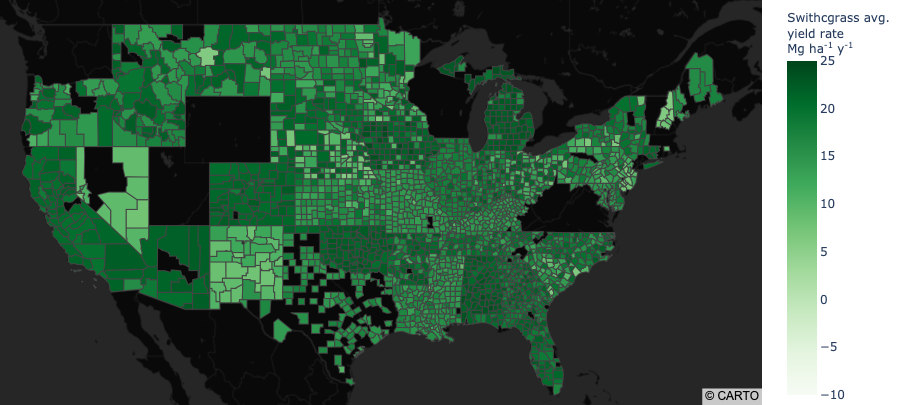

In [25]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha', 'Greens', 'Swithcgrass avg.<br>yield rate<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [-10, 25]})

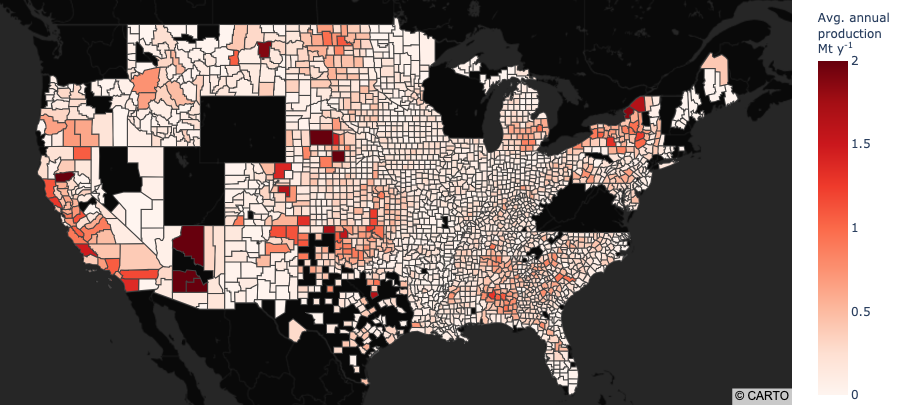

In [26]:
mapping(county_df[county_df.variety == 'base'],
        'prod_Mt', 'Reds', 'Avg. annual<br>production<br>Mt y<sup>-1</sup>',
        kwargs={"range_color": [0.0, 2.0]})

In [27]:
BREAK

NameError: name 'BREAK' is not defined

# Explore inter-annual yield variability

## Map precipitation gradients

In [ ]:
mapping(county_df[county_df.variety == 'base'],
        'annual_precip_cm', 'Blues', 'Avg. annual<br>precip. (cm)')

## Map yield STD & COV

In [ ]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha_std', 'Reds', 'Yield STD<br>Mg ha<sup>-1</sup> y<sup>-1</sup>')

In [ ]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha_cov', 'Reds', 'Yield COV')

# Yield comparisons

## CBI switchgrass vs. CABBI Miscanthus

In [ ]:
# read list of all county FIPS codes (for exploring missing counties)
fips_df = pd.read_csv('01_raw_inputs/All_FIPS.csv')
fips_df['fips'] = fips_df['FIPS'].apply(lambda x: '{0:0>5}'.format(x))

# read in CABBI Miscanthus yield data
cabbi_file = "01_raw_inputs/miscanthus_county_averages_20211223.csv"
cabbi_df = pd.read_csv(cabbi_file)
cabbi_df['fips'] = cabbi_df['nearestfips'].apply(lambda x: '{0:0>5}'.format(x))
cabbi_df['CABBI_yield_Mg_per_ha'] = cabbi_df['crmvst'] * 0.01 * (1.0/0.45)
cabbi_df

In [ ]:
mapping(cabbi_df,
        'CABBI_yield_Mg_per_ha', 'Greens', 'Avg. yield rate<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [0, 25]})

In [ ]:
comp_df = pd.merge(county_df, cabbi_df, on='fips', how='outer')
comp_df = pd.merge(fips_df, comp_df, on='fips', how='outer')
comp_df

In [ ]:
# map yield comparison

comp_df['Misc-SWG_yield_per_ha'] = comp_df.CABBI_yield_Mg_per_ha - comp_df.yield_Mg_per_ha

mapping(comp_df,
        'Misc-SWG_yield_per_ha', 'BrBG', 'Miscanthus<br>yield advantage<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [-12, 12]})

## Comparison to PRISM-EM / BT23

In [ ]:
# model yields in PRISM-ELM paper colors

# map continuous yields to discreet bins
def yield_rules(col):

    rules = {
        '0-1': (comp_df[col] < 1.0),
        '1-3': (comp_df[col] >= 1.0) & (comp_df[col] < 3.0),
        '3-6': (comp_df[col] >= 3.0) & (comp_df[col] < 6.0),
        '6-10': (comp_df[col] >= 6.0) & (comp_df[col] < 10.0),
        '10-14': (comp_df[col] >= 10.0) & (comp_df[col] < 14.0),
        '14-18': (comp_df[col] >= 14.0) & (comp_df[col] < 18.0),
        '18-22': (comp_df[col] >= 18.0) & (comp_df[col] < 22.0),
        '>22': (comp_df[col] >= 22.0)
    }
    return rules

comp_df['SWG_yield_bins'] = np.select(yield_rules('yield_Mg_per_ha').values(), yield_rules('yield_Mg_per_ha').keys(), default="")
comp_df['Misc_yield_bins'] = np.select(yield_rules('CABBI_yield_Mg_per_ha').values(), yield_rules('CABBI_yield_Mg_per_ha').keys(), default="")
comp_df

In [ ]:
prism_colors = {
    '0-1': 'rgb(135,110,64)',
    '1-3': 'rgb(204,168,100)',
    '3-6': 'rgb(243,217,164)',
    '6-10': 'rgb(254,255,214)',
    '10-14': 'rgb(169,232,145)',
    '14-18': 'rgb(108,194,111)',
    '18-22': 'rgb(70,153,71)',
    '>22': 'rgb(38,114,0)'
    }


In [ ]:
# map CBI switchgrass yield in the style of PRISM papers (for easy visual comparison)

interactive_map = False
my_map = px.choropleth_mapbox(comp_df[comp_df.SWG_yield_bins != ''], geojson=counties, locations='fips',
                              color='SWG_yield_bins',
                              color_discrete_map=prism_colors,
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'SWG_yield_bins': 'Switchgrass yield<br>Mg ha<sup>-1</sup> y<sup>-1</sup>'},
                              category_orders={"SWG_yield_bins": ['0-1', '1-3', '3-6', '6-10', '10-14', '14-18', '18-22', '>22']})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
my_map.update_traces(marker_line_width=0.2)

name = 'SWG_prism_yield'
if interactive_map:
    my_map.show()
else:
    my_map.write_image('03_figure_outputs/' + name+".png")
    display(Image(filename=('03_figure_outputs/' + name+".png")))
# my_map.write_image('03_figure_outputs/' + name+".pdf")

This yield map can be compared to the equivalents for lowland and upland switchgrass from Lee et al. 2018: 

![Lee et al. 2018 lowland switchgrass yield map](00_graphics/Lee2018-LowlandSwitchgrass.png)

*PRISM-EM estimate of lowland switchgrass yield potential, from Lee et al. 2018 Fig. 2.*

![Lee et al. 2018 upland switchgrass yield map](00_graphics/Lee2018-UplandSwitchgrass.png)

*PRISM-EM estimate of upland switchgrass yield potential, from Lee et al. 2018 Fig. 2.*

In [ ]:
# map CABBI Miscanthus yield in the style of PRISM papers (for easy visual comparison)

interactive_map = False
my_map = px.choropleth_mapbox(comp_df[comp_df.Misc_yield_bins != ''], geojson=counties, locations='fips',
                              color='Misc_yield_bins',
                              color_discrete_map=prism_colors,
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'Misc_yield_bins': 'Miscanthus yield<br>Mg ha<sup>-1</sup> y<sup>-1</sup>'},
                              category_orders={"Misc_yield_bins": ['0-1', '1-3', '3-6', '6-10', '10-14', '14-18', '18-22', '>22']})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
my_map.update_traces(marker_line_width=0.2)

name = 'Misc_prism_yield'
if interactive_map:
    my_map.show()
else:
    my_map.write_image('03_figure_outputs/' + name+".png")
    display(Image(filename=('03_figure_outputs/' + name+".png")))
# my_map.write_image('03_figure_outputs/' + name+".pdf")

This CABBI Miscanthus yield map can be compared to the equivalent from Lee et al. 2018: 

![Lee et al. 2018 Miscanthus yield map](00_graphics/Lee2018-Miscanthus.png)

*PRISM-EM estimate of Miscanthus switchgrass yield potential, from Lee et al. 2018 Fig. 4.*

# Land use and modeling extent

## Cropland & abandoned land

Comparing the amount of abandoned land as per Zumkehr & Campbell 2013, versus active annual cropland area (i.e., “harvested”, “failed”, and “summer fallow” as per the 2017 Census of Agriculture, but excluding idle cropland and cropland–pasture, following Lark et al., 2020)

In [ ]:
peak_df = run_df[['fips', 'peak_year']].groupby('fips').mean()
peak_df.reset_index(inplace=True)
peak_df['fips'] = peak_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
peak_df

In [ ]:
mapping(peak_df, 'peak_year', 'RdYlBu_r', 'Year of peak<br>cropland extent')
# mapping(peak_df, 'peak_year', 'RdYlBu_r', 'Year of peak<br>cropland extent', kwargs={"range_color": [1850, 2000]})

This map can be verified against the equivalent from Zumkehr & Campbell 2013, based on which our simulations were originally specified: 

![Zumkehr & Campbell 2013 year of peak cropland extent](00_graphics/ZC2013-PeakYear.png)

*Year of peak extent of annual cropland, from Zumkehr & Campbell 2013 Fig. 3. Note that we have truncated the DayCent simulation specification such that any land abandoned prior to 1950 is simulated as having been abandoned in 1950, to align with standard model spin-up workflows.*

In [ ]:
coa_df = pd.read_csv('/Users/53f/ORNL_OneDrive/Notebooks/SPARC/NARR-CoA_comparison/coa_ha.csv')
coa_df['fips'] = coa_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
coa_df

In [ ]:
mapping(coa_df,
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)',
       kwargs={"range_color": [0, 100]})

In [ ]:
comp_df = pd.merge(comp_df, coa_df, on='fips', how='outer')
comp_df['abandoned_pct'] = (comp_df.tot_ha / comp_df.county_ha) * 100.0
comp_df['abandoned_to_active_cropland'] = comp_df.tot_ha / comp_df.CoA_tot_0_ha
comp_df

In [ ]:
mapping(comp_df,
        'abandoned_pct', 'Oranges', 'Abandoned<br>cropland area<br>(%)',
       kwargs={"range_color": [0, 30]})

This map can be verified against the equivalent from Zumkehr & Campbell 2013, based on which our simulations were originally specified: 

![Zumkehr & Campbell 2013 year of peak cropland extent](00_graphics/ZC2013-CorrectedAbandonedLand.png)

*Abandoned cropland extent after subtracting land that may have been reforested or urbanized, from Zumkehr & Campbell 2013 Fig. 3. This is their estimate of abandoned cropland potentially available for bioenergy production. Note that this original analysis is visualized on a 4 km grid, whereas the prior figure shows county average values from the DayCent workflow (and thus the peak values are lower).*

In [ ]:
mapping(comp_df,
        'abandoned_to_active_cropland', 'RdBu_r', 'Abandoned:active<br>cropland',
       kwargs={"range_color": [0, 2]})

## Missing counties

Explore whether gaps in CBI switchgrass & CABBI Miscanthus results datasets are counties with significant amounts of active annual cropland or abandoned land. 

In [ ]:
missing_df = fips_df.merge(county_df.drop_duplicates(), on='fips', how='left', indicator=True)

mapping(missing_df[missing_df._merge == 'left_only'],
        'FIPS', 'Viridis', '', kwargs={"range_color": [0, 1000]})

In [ ]:
# map out gaps in the maps

rules = {
    'Both': (~comp_df.yield_Mg_per_ha.isna()) & (~comp_df.CABBI_yield_Mg_per_ha.isna()),
    'No switchgrass': (comp_df.yield_Mg_per_ha.isna()) & (~comp_df.CABBI_yield_Mg_per_ha.isna()),
    'No miscanthus': (~comp_df.yield_Mg_per_ha.isna()) & (comp_df.CABBI_yield_Mg_per_ha.isna()),
    'Neither': (comp_df.yield_Mg_per_ha.isna()) & (comp_df.CABBI_yield_Mg_per_ha.isna())
}

comp_df['missing'] = np.select(rules.values(), rules.keys(), default="")
comp_df

In [ ]:
missing_df = comp_df[comp_df.missing != "Both"].copy()

my_map = px.choropleth_mapbox(missing_df, geojson=counties, locations='fips',
                              color='missing',
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'missing': 'Missing data'})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
if interactive_map:
    my_map.show()
else:
    my_map.write_image("03_figure_outputs/Missing.png")
    display(Image(filename="03_figure_outputs/Missing.png"))
# my_map.write_image("03_figure_outputs/Missing.pdf")

In [ ]:
# convert 'missing' column to binary indicators for miscanthus and switchgrass data separately
rules = {
    'Data': comp_df.missing.isin(['Both', 'No switchgrass']),
    'No data': comp_df.missing.isin(['No miscanthus', "Neither"])
}
comp_df['Misc_data'] = np.select(rules.values(), rules.keys())

rules = {
    'Data': comp_df.missing.isin(['Both', 'No miscanthus']),
    'No data': comp_df.missing.isin(['No switchgrass', "Neither"])
}
comp_df['SWG_data'] = np.select(rules.values(), rules.keys())

comp_df

In [ ]:
mapping(comp_df[comp_df.missing.isin(['No miscanthus', 'Neither'])],
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)', descrip='_Misc_missing',
       kwargs={"range_color": [0, 100]})

In [ ]:
mapping(comp_df[comp_df.missing.isin(['No miscanthus', 'Neither'])],
        'tot_ha', 'Oranges', 'Abandoned land<br>area (ha)', descrip='_Misc_missing',
       kwargs={"range_color": [0, 120e3]})

In [ ]:
mapping(comp_df[comp_df.missing.isin(['No switchgrass', 'Neither'])],
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)', descrip='_SWG_missing',
       kwargs={"range_color": [0, 100]})

# Exploring yield sensitivity to precipitation

## Map yield-precip correlation

In [ ]:
# create list to store regression results
reg_results = []

# create dataframe to store full annual_df plus a normalized column
norm_cols = [x for x in annual_df.columns]
norm_df = pd.DataFrame(columns=norm_cols)

# subset the annual data from each county, one at a time
counties = annual_df['fips'].unique()
for county in counties:
    my_county = annual_df[annual_df['fips'] == county].copy()
    
    # regress annual yield vs. annual precipitation w/in the county
    X = my_county.annual_precip_cm
    Y = my_county.yield_Mg_per_ha
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    r2 = est2.rsquared_adj
    
    reg_results.append([county, r2])
    
    # normalize annual results against best-yielding year
    best_yield = my_county.yield_Mg_per_ha.max()
    my_county['norm_yield'] = my_county.yield_Mg_per_ha / best_yield
    
    norm_df = pd.concat([norm_df, my_county], axis=0)

norm_df.to_csv('02_intermediate_outputs/' + base_sims+'-annual_norm.csv', index=False)
    
# convert regression results array to DataFrame
reg_df = pd.DataFrame(reg_results, columns =['fips', 'r2'])
reg_df.to_csv('02_intermediate_outputs/' + base_sims+'-yield_precip_r2s.csv', index=False)
reg_df

In [ ]:
mapping(reg_df,
        'r2', 'Purples', 'Yield-precip<br>correlation strength<br>r<sup>2</sup>')

## Yield-precip sensitivity by Farm Resource Region

We can discretize our yield-vs-precipitation analysis by Farm Resource Region, using the FIPS lookup table archived at https://wayback.archive-it.org/5923/20110913212900/http:/www.ers.usda.gov/Briefing/ARMS/resourceregions/resourceregions.htm

In [ ]:
frr_df = pd.read_excel("01_raw_inputs/FRR_data.xls", sheet_name='data')
lookup_df = pd.read_excel("01_raw_inputs/FRR_data.xls", sheet_name='lookup')
frr_df = pd.merge(lookup_df, frr_df, on='FRR', validate="1:m")
frr_df['fips'] = frr_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
frr_df

In [ ]:
interactive_map = False
my_map = px.choropleth_mapbox(frr_df, geojson=counties, locations='fips',
                              color='Region_name',
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'Region_name': 'Farm Resource Region'})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
if interactive_map:
    my_map.show()
else:
    my_map.write_image("03_figure_outputs/FRR.png")
    display(Image(filename="03_figure_outputs/FRR.png"))
# my_map.write_image("03_figure_outputs/FRR.pdf")

In [ ]:
# merge FRR data into normalized annual dataframe

norm_df = pd.merge(norm_df, frr_df, on='fips')
norm_df

In [ ]:
frr_panels = [
[['Basin and Range', '#B6E880'], ['Northern Great Plains', '#00CC96'], ['Northern Crescent', '#EF553B']],
[['Fruitful Rim', '#FF6692'], ['Heartland', '#636EFA'], ['Eastern Uplands', '#FFA15A']],
[['Prairie Gateway', '#AB63FA'], ['Mississippi Portal', '#FF97FF'], ['Southern Seaboard', '#19D3F3']]
]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(11, 9), nrows=len(frr_panels), ncols=len(frr_panels[1]), sharex=True, sharey=True)
fig.suptitle('Regional yield sensitivity to precipitation')
ax[2, 1].set_xlabel("Annual precipitation (cm)")
ax[1, 0].set_ylabel("Normalized yield (relative to inter-annual maximum)")
ax[0, 0].set_xlim([0, 220])

# iterate through panel structure
for i in range(len(frr_panels)):
    for j in range(len(frr_panels[i])):
        region, color = frr_panels[i][j]
        ax[i, j].set_title(region)
        data = norm_df[norm_df.Region_name == region]
        
        # plot normalized yield response to precipitation
        ax[i, j].scatter(data.annual_precip_cm, data.norm_yield, color=color, alpha=0.05, s=2)

plt.tight_layout()
# plt.savefig('Norm_yield-vs-precip-by-FRR.pdf')
plt.savefig('03_figure_outputs/Norm_yield-vs-precip-by-FRR.png')

# Soil C change

In [ ]:
# map change in SOC since beginning of simulation
county_df['SOCgain_MgC_per_ha'] = county_df['SOC_MgC_per_ha'] - county_df['initSOC_MgC_per_ha']

mapping(county_df, 'initSOC_MgC_per_ha', 'RdYlGn', 'Simulated initial<br>0-20cm SOC stocks<br>(Mg C ha<sup>-1</sup>)',
    kwargs={"range_color": [0, 100]})

In [ ]:
mapping(county_df, 'SOC_MgC_per_ha', 'RdYlGn', 'Simulated final<br>0-20cm SOC stocks<br>(Mg C ha<sup>-1</sup>)',
    kwargs={"range_color": [0, 100]})

In [ ]:
mapping(county_df, 'SOCgain_MgC_per_ha', 'Reds', 'Simulated gain in<br>0-20cm SOC stocks<br>(Mg C ha<sup>-1</sup>)',
    kwargs={"range_color": [0, 35]})

In [ ]:
# explore SOC vs. peak cropland extent year (i.e., time since abanonment)

# merge in peak cropland year data
county_df = county_df.merge(peak_df, on='fips')

# bin the peak_year into appropriate intervals for boxplot
county_df['peak_year_binned'] = pd.cut(county_df['peak_year'], bins=range(1950, 2000, 5), right=False)
county_df

In [ ]:
# create box and whisker plot of SOC gain since abandonment

plt.figure(figsize=(12, 6))
sns.boxplot(x='peak_year_binned', y='SOCgain_MgC_per_ha', data=county_df, color='C1')
plt.xlabel('Start of net land abandonment (binned)')
plt.ylabel('SOC gain since beginning of abandonment (MgC per ha)')
plt.xticks(rotation=45)
plt.savefig('03_figure_outputs/SOC_gain-v-abandonment_start.png')
plt.show()

In [ ]:
# create box and whisker plot of initial SOC at time of peak cropland extent

plt.figure(figsize=(12, 6))
sns.boxplot(x='peak_year_binned', y='initSOC_MgC_per_ha', data=county_df, color='C1')
plt.xlabel('Start of net land abandonment (binned)')
plt.ylabel('Initial SOC at abandonment (MgC per ha)')
plt.xticks(rotation=45)
plt.savefig('03_figure_outputs/InitialSOC_gain_at_abandonment_start.png')
plt.show()

In [ ]:
# create box and whisker plot of SOC change since switchgrass establishment

plt.figure(figsize=(12, 6))
sns.boxplot(x='peak_year_binned', y='dSOC_MgC_per_ha', data=county_df, color='C1')
plt.xlabel('Start of net land abandonment (binned)')
plt.ylabel('SOC change since switchgrass \n establishment (MgC per ha)')
plt.xticks(rotation=45)
plt.savefig('03_figure_outputs/dSOC-v-abandonment_start.png')
plt.show()

# Code fragments

In [ ]:
# def soil_stats(mukey):

#     soil_cols = ['upper_depth_cm', 'lower_depth_cm', 'BD_g_cm3', 'FC', 'WP', 'evap_coef', 'frac_roots', 'sand', 'clay', 'OM',
#                     'SWCmin', 'ksat_cm_s', 'pH']
#     soils_path = '/Users/53f/Desktop/Local_datasets/IA_soils/'
    
#     # read soils data, and create a dictionary for storing soil property calculation results
#     soil_dir = str(mukey)[:-3]
#     soil_fpath = os.path.join(soils_path, soil_dir, "{}.in".format(mukey))
#     soil_df = pd.read_csv(soil_fpath, names=soil_cols, delimiter='\t')
#     properties = {}

#     # compute individual layer properties
#     soil_df['WHC_cm'] = (soil_df.FC - soil_df.WP) * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)
#     soil_df['sand_cm'] = soil_df.sand * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)
#     soil_df['clay_cm'] = soil_df.clay * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)

#     # extract & record individual properties of interset
#     properties['mukey'] = mukey
    
#     properties['WHC_cm'] = soil_df.WHC_cm.sum()
#     properties['ksat_surf'] = soil_df.ksat_cm_s[0]
#     properties['ksat_min'] = soil_df.ksat_cm_s.min()

#     properties['sand_surf'] = soil_df.sand[0]
#     properties['clay_surf'] = soil_df.clay[0]

#     last_i = soil_df.index[-1]
#     properties['sand_prof'] = soil_df.sand_cm.sum() / soil_df.lower_depth_cm[last_i]
#     properties['clay_prof'] = soil_df.clay_cm.sum() / soil_df.lower_depth_cm[last_i]

#     return properties

## Yield–soil comparison

In [ ]:
# # subset & re-merge the data to calculate variety-driven differences in yield & dSOC
# cs_raw_df = cs_df[['fips', 'County', 'ST', 'strata_no', 'variety', 'time', 'NARR_year', 'annual_precip_cm', 'yield_Mg_ha', 'dSOC_MgC_ha']]
# cs_variety_df = cs_raw_df[cs_raw_df.variety == 'base']
# cs_drought_df = cs_raw_df[cs_raw_df.variety == 'drought_tol']
# cs_variety_df = pd.merge(cs_variety_df, cs_drought_df, on=['fips', 'County', 'ST', 'strata_no', 'time', 'NARR_year', 'annual_precip_cm'], 
#                          suffixes=('_base', '_drought_tol'))

# cs_variety_df['variety_yield_gain_Mg_ha'] = cs_variety_df.yield_Mg_ha_drought_tol - cs_variety_df.yield_Mg_ha_base
# cs_variety_df['variety_dSOC_gain_Mg_ha'] = cs_variety_df.dSOC_MgC_ha_drought_tol - cs_variety_df.dSOC_MgC_ha_base
# cs_variety_df.drop(columns=['variety_base', 'variety_drought_tol'], inplace=True)

# # re-associate w/ run_df to get soil & weather IDs for each strata
# cs_variety_df = pd.merge(cs_variety_df, run_df[['strata_no', 'mukey_int', 'gridx', 'gridy', 'latitude', 'peak_year']], on='strata_no')
# cs_variety_df

In [ ]:
# # determine soils.in data that should be downloaded for further analysis

# # # count unique SSURGO map units in full case study dataset
# # mukeys = cs_variety_df.mukey_int.unique().tolist()
# # soil_dirs = [str(x)[:-3] for x in mukeys]
# # set(soil_dirs)

# # filter dataset down to a subset with common county, NARR grid, and peak year, to isolate soil effects
# cs_variety_df.value_counts(['fips', 'gridx', 'gridy', 'peak_year'])
# ##fips   gridx  gridy  peak_year
# ##19159  113    207    1970         2695
# cs_soils_df = cs_variety_df[(cs_variety_df.fips == 19159) & (cs_variety_df.gridx == 113) & (cs_variety_df.gridy == 207) & (cs_variety_df.peak_year == 1970)]
# unique_soils = cs_soils_df.mukey_int.unique()
# unique_soils

In [ ]:
# # loop through case study subset mukeys, run soil property function, and store results in a nested list

# soil_data = [['mukey_int', 'WHC_cm', 'ksat_surf', 'ksat_min', 'sand_surf', 'clay_surf', 'sand_prof', 'clay_prof']]
# for mukey in unique_soils:
#     soil_props = soil_stats(mukey)
#     soil_data.append(list(soil_props.values()))

# # convert nested results list to a DataFrame, and merge with case study subset DataFrame
# soil_props_df = pd.DataFrame(soil_data[1:], columns=soil_data[0])
# soil_props_df

# cs_soils_df = pd.merge(cs_soils_df, soil_props_df, on='mukey_int', how='left')
# cs_soils_df

In [ ]:
# ids = "_" + base_sims.split("_")[0] + "_" + drought_sims.split("_")[0]

# fig1, ax1 = plt.subplots()
# ax1 = cs_soils_df.plot.scatter(x='annual_precip_cm', y='yield_Mg_ha_base', c='WHC_cm', colormap='viridis', ax=ax1)
# fig1.savefig("Base_yield-vs-precip-by-WHC" + ids + ".pdf")

In [ ]:
# fig2, ax2 = plt.subplots()
# ax2 = cs_soils_df.plot.scatter(x='WHC_cm', y='variety_yield_gain_Mg_ha', c='annual_precip_cm', colormap='viridis', ax=ax2)
# ax2.axhline(color='k')
# fig2.savefig("Yield_gain-vs-WHC-by-precip" + ids + ".pdf")

In [ ]:
# ssurgo_metadata_fpath = '/Users/johnfield/Desktop/GCEP_local/ssurgo2012_texture_depth.csv'
# soil_df = pd.read_csv(ssurgo_metadata_fpath)

# cs_soil_df = pd.merge(cs_soil_df[['strata_no', 'time', 'yield_Mg_ha']],
#                       run_df[['strata_no', 'mukey_int', 'peak_year']],
#                       on='strata_no')
# cs_soil_df = pd.merge(cs_soil_df, soil_df, left_on='mukey_int', right_on='mukey')

# cs_soil_df['peak_year'].value_counts()
# # cs_soil_df.hist(column='peak_year')

# cs_soil_df.plot.scatter(x='depth', y='yield_Mg_ha')

## Climate analysis
Here's some initial exploratory code to parse a DayCent-format weather file and analyze inter-annual variability in growing-season temperatures and precipitation.

In [ ]:
# weather_file1 = "NARR_89_234.wth"
# weather_df1 = pd.read_csv(weather_file1, sep='\t', usecols=range(1, 7),
#                          names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
# weather_file2 = "NARR_89_231.wth"
# weather_df2 = pd.read_csv(weather_file2, sep='\t', usecols=range(1, 7),
#                          names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
# weather_df2

In [ ]:
# wth_df = pd.merge(weather_df1, weather_df2, on=['Month', 'Year', 'DayOfYear'], suffixes=['_234', '_231'])
# seasonal_wth_df = wth_df[wth_df['Month'].isin([5, 6, 7, 8, 9])]
# seasonal_wth_df['Tavg_C_231'] = (seasonal_wth_df['Tmin_C_231'] + seasonal_wth_df['Tmax_C_231']) / 2.0
# seasonal_wth_df['Tavg_C_234'] = (seasonal_wth_df['Tmin_C_234'] + seasonal_wth_df['Tmax_C_234']) / 2.0
# annunal_wth_df = seasonal_wth_df.groupby('Year').agg({'Tmax_C_231': 'mean',
#                                                       'Tavg_C_231': 'mean',
#                                                       'Precip_cm_231': 'sum',
#                                                       'Tmax_C_234': 'mean',
#                                                       'Tavg_C_234': 'mean',
#                                                       'Precip_cm_234': 'sum'})
# annunal_wth_df['Precip_diff_cm'] = annunal_wth_df['Precip_cm_231'] - annunal_wth_df['Precip_cm_234']
# annunal_wth_df.head()

In [ ]:
# fig = plt.figure()
# spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1, 2])
# fig.suptitle("Difference between two weather grid centroids, 100km apart")

# ax0 = fig.add_subplot(spec[0])
# ax0.bar(annunal_wth_df.index, annunal_wth_df.Precip_diff_cm)
# plt.setp(ax0.get_xticklabels(), visible=False)
# plt.ylabel("Difference (cm)")

# ax1 = fig.add_subplot(spec[1], sharex=ax0)
# ax1.plot(annunal_wth_df.Precip_cm_231)
# ax1.plot(annunal_wth_df.Precip_cm_234)
# plt.xlabel("Year")
# plt.ylabel("May–Sept. total precip (cm)")

In [ ]:
# plt.scatter(annunal_wth_df.Tavg_C_231, annunal_wth_df.Precip_cm_231)
# plt.title("Inter-annual variability in growing season weather")
# plt.xlabel("May–Sept. average air temperature (C)")
# plt.ylabel("May–Sept. total precipitation (cm)")

In [ ]:
# print total notebook execution time

end_time = datetime.now()
print('Notebook execution duration: {}'.format(end_time - start_time))